In [2]:
import zipfile
import os


with zipfile.ZipFile("/content/GPUPy.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

In [3]:

os.listdir("/content/")

import sys
sys.path.append("/content")

In [11]:
import numpy as np
import cupy as cp
from GPUPy.src.numerical_methods.integration import *
from GPUPy.src.numerical_methods.utils import benchmark

def heavy_function(x):
    xp = cp.get_array_module(x)
    return xp.sin(x) * xp.exp(-x**2)


def run_benchmarks():
    # Create sample data
    a, b = 0, np.pi
    num_points = 10**6
    x = np.linspace(a, b, num_points)
    y = np.sin(x)

    # Benchmark trapezoidal_integral
    print("Benchmarking trapezoidal_integral...")

    cpu_time = benchmark(trapezoidal_integral, x, y, use_gpu=False)
    print(f"CPU time (trapezoidal): {cpu_time:.6f} seconds")

    try:
        import cupy as cp  # check if GPU is available
        x_gpu = cp.asarray(x)
        y_gpu = cp.asarray(y)
        gpu_time = benchmark(trapezoidal_integral, x, y, use_gpu=True)
        print(f"GPU time (trapezoidal): {gpu_time:.6f} seconds")
    except ImportError:
        print("CuPy not installed. Skipping GPU benchmark for trapezoidal_integral.")

    # Benchmark analytical_integral
    print("\nBenchmarking analytical_integral...")

    cpu_time = benchmark(analytical_integral, heavy_function, a, b, use_gpu=False)
    print(f"CPU time (analytical): {cpu_time:.6f} seconds")

    try:
        gpu_time = benchmark(analytical_integral, heavy_function, a, b, use_gpu=True, num_points=num_points)
        print(f"GPU time (analytical): {gpu_time:.6f} seconds")
    except ImportError:
        print("CuPy not installed. Skipping GPU benchmark for analytical_integral.")

if __name__ == "__main__":
    run_benchmarks()



Benchmarking trapezoidal_integral...
CPU time (trapezoidal): 0.007667 seconds
GPU time (trapezoidal): 0.003000 seconds

Benchmarking analytical_integral...
CPU time (analytical): 0.000068 seconds
GPU time (analytical): 2.865845 seconds


Starting integration benchmark...
Running integration benchmarks...
Size       CPU Trap (s)    GPU Trap (s)    CPU Analytical (s) GPU Analytical (s)
100        0.000011        0.000349        0.000040        0.000417       
1000       0.000012        0.000319        0.000047        0.000356       
10000      0.000031        0.000310        0.000041        0.000449       
100000     0.000319        0.000488        0.000043        0.000364       
1000000    0.007213        0.003249        0.000046        0.001436       


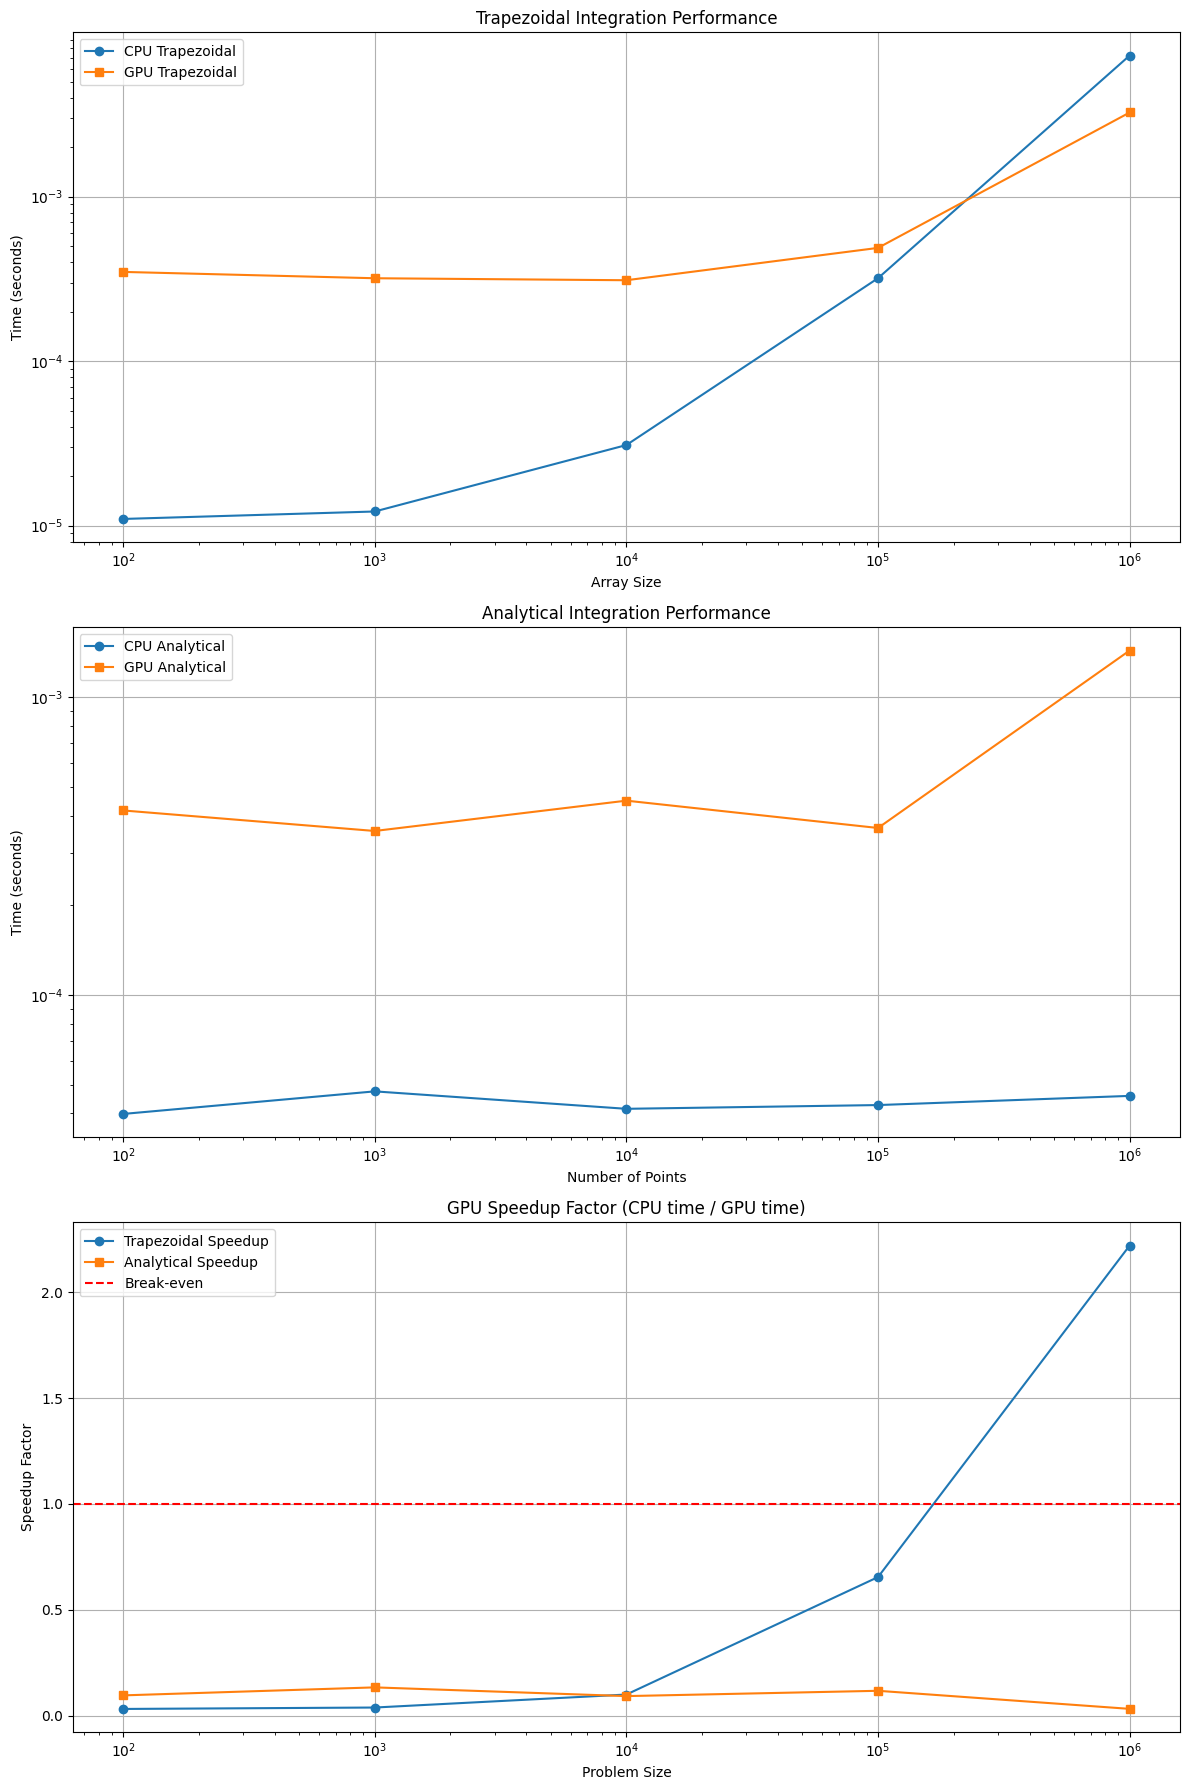

Benchmark complete. Results saved to integration_benchmark_results.png


In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
from GPUPy.src.numerical_methods.integration import trapezoidal_integral, analytical_integral

def benchmark(method_func, *args, repeats=5, **kwargs):
    """
    Benchmark a function by measuring its execution time.

    Parameters:
        method_func (callable): Function to benchmark
        *args: Positional arguments to pass to the function
        repeats (int): Number of times to repeat the measurement
        **kwargs: Keyword arguments to pass to the function

    Returns:
        float: Average execution time in seconds
    """
    # Initial call to validate (not timed)
    # We do this outside the loop to handle any initial validation
    method_func(*args, **kwargs)

    # Now time the method calls
    durations = []
    for _ in range(repeats):
        start = time.perf_counter()
        method_func(*args, **kwargs)
        durations.append(time.perf_counter() - start)

    avg_time = sum(durations) / repeats
    return avg_time

def run_integration_benchmarks():
    """
    Run benchmarks comparing CPU and GPU integration performance
    for different problem sizes.
    """
    # Test function to integrate
    def test_func(x):
        return np.sin(x) * np.exp(-0.1 * x)

    # Define problem sizes to test
    sizes = [100, 1000, 10000, 100000, 1000000]

    # Storage for results
    cpu_times_trap = []
    gpu_times_trap = []
    cpu_times_analytical = []
    gpu_times_analytical = []

    print("Running integration benchmarks...")
    print("{:<10} {:<15} {:<15} {:<15} {:<15}".format(
        "Size", "CPU Trap (s)", "GPU Trap (s)", "CPU Analytical (s)", "GPU Analytical (s)"))

    # Run benchmarks for each size
    for size in sizes:
        # Create data for trapezoidal rule
        x = np.linspace(0, 10, size)
        y = test_func(x)

        # Benchmark trapezoidal integration
        cpu_time_trap = benchmark(trapezoidal_integral, x, y, use_gpu=False)
        gpu_time_trap = benchmark(trapezoidal_integral, x, y, use_gpu=True)

        # Benchmark analytical integration
        cpu_time_analytical = benchmark(analytical_integral, test_func, 0, 10, use_gpu=False)
        gpu_time_analytical = benchmark(analytical_integral, test_func, 0, 10,
                                      use_gpu=True, num_points=size)

        # Store results
        cpu_times_trap.append(cpu_time_trap)
        gpu_times_trap.append(gpu_time_trap)
        cpu_times_analytical.append(cpu_time_analytical)
        gpu_times_analytical.append(gpu_time_analytical)

        # Print results
        print("{:<10} {:<15.6f} {:<15.6f} {:<15.6f} {:<15.6f}".format(
            size, cpu_time_trap, gpu_time_trap, cpu_time_analytical, gpu_time_analytical))

    # Calculate speedup
    speedup_trap = [cpu/gpu if gpu > 0 else 0 for cpu, gpu in zip(cpu_times_trap, gpu_times_trap)]
    speedup_analytical = [cpu/gpu if gpu > 0 else 0 for cpu, gpu in zip(cpu_times_analytical, gpu_times_analytical)]

    # Plot results
    plot_benchmark_results(sizes, cpu_times_trap, gpu_times_trap,
                          cpu_times_analytical, gpu_times_analytical,
                          speedup_trap, speedup_analytical)

    return {
        'sizes': sizes,
        'cpu_times_trap': cpu_times_trap,
        'gpu_times_trap': gpu_times_trap,
        'cpu_times_analytical': cpu_times_analytical,
        'gpu_times_analytical': gpu_times_analytical,
        'speedup_trap': speedup_trap,
        'speedup_analytical': speedup_analytical
    }

def plot_benchmark_results(sizes, cpu_times_trap, gpu_times_trap,
                          cpu_times_analytical, gpu_times_analytical,
                          speedup_trap, speedup_analytical):
    """
    Create visualization of benchmark results.
    """
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

    # Plot 1: Execution times for trapezoidal integration
    ax1.plot(sizes, cpu_times_trap, 'o-', label='CPU Trapezoidal')
    ax1.plot(sizes, gpu_times_trap, 's-', label='GPU Trapezoidal')
    ax1.set_title('Trapezoidal Integration Performance')
    ax1.set_xlabel('Array Size')
    ax1.set_ylabel('Time (seconds)')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.grid(True)
    ax1.legend()

    # Plot 2: Execution times for analytical integration
    ax2.plot(sizes, cpu_times_analytical, 'o-', label='CPU Analytical')
    ax2.plot(sizes, gpu_times_analytical, 's-', label='GPU Analytical')
    ax2.set_title('Analytical Integration Performance')
    ax2.set_xlabel('Number of Points')
    ax2.set_ylabel('Time (seconds)')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.grid(True)
    ax2.legend()

    # Plot 3: Speedup
    ax3.plot(sizes, speedup_trap, 'o-', label='Trapezoidal Speedup')
    ax3.plot(sizes, speedup_analytical, 's-', label='Analytical Speedup')
    ax3.axhline(y=1, color='r', linestyle='--', label='Break-even')
    ax3.set_title('GPU Speedup Factor (CPU time / GPU time)')
    ax3.set_xlabel('Problem Size')
    ax3.set_ylabel('Speedup Factor')
    ax3.set_xscale('log')
    ax3.grid(True)
    ax3.legend()

    plt.tight_layout()
    plt.savefig('integration_benchmark_results.png')
    plt.show()

if __name__ == "__main__":
    print("Starting integration benchmark...")
    results = run_integration_benchmarks()
    print("Benchmark complete. Results saved to integration_benchmark_results.png")